In [79]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
import statsmodels.stats.api as stats
import statsmodels.formula.api as smf

from sksurv.nonparametric import kaplan_meier_estimator

from warnings import simplefilter
simplefilter('ignore', category=DeprecationWarning)
simplefilter('ignore', category=FutureWarning)
from logging import warning as warn

import os
from dotenv import load_dotenv; load_dotenv('../.env')
from mysql.connector import connect

# Datos de Paciente


In [80]:
pat1 = pd.read_csv('../data/raw/patients_batch1.csv', parse_dates = ['birth_date', 'diagnosis_date', 'death_date'], dayfirst = True)
pat2 = pd.read_csv('../data/raw/patients_batch2.csv', parse_dates = ['birth_date', 'diagnosis_date', 'death_date'], dayfirst = True)
print("Dimensión de Conjunto 1: ", pat1.shape[0])
print("Dimensión de Conjunto 2: ", pat2.shape[0])
display(pat1.head())


Dimensión de Conjunto 1:  7500
Dimensión de Conjunto 2:  3000


,ehr,birth_date,diagnosis_date,death_date
0,10011773,1959-07-05,2015-04-02,NaT
1,10020495,1953-10-02,2017-12-04,NaT
2,10030299,1966-08-16,2019-06-27,NaT
3,10030824,1953-03-03,2018-09-07,NaT
4,10041592,1959-07-06,2018-11-19,NaT


In [81]:
def preprocess_patients(pat, check_filter: bool = False):
    """
    Preprocesado de los Pacientes. Añade columnas, elimina / imputa nulos.
    """

    pat = pat.copy()
    now = pd.Timestamp.now()

    pat['is_alive']   = pat['death_date'].isna()
    pat['age']   = (now - pat['birth_date']) / np.timedelta64(1, 'Y')
    pat['age']   = pat['age'].astype(int)

    if check_filter: assert all(pat['age'] > 0), "Hay personas con nacidas en el fúturo. Fecha de nacimiento superior a fecha actual"
    else:
        mask1 = pat['age'] < 0
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} personas con nacidas en el fúturo. Fecha de nacimiento superior a fecha actual. Se han eliminado. Limpiando linea temporal")
            
        pat.loc[mask1, 'age'] = np.nan

    # Comprobations
    pat['diag_dur']   = (pat['death_date'] - pat['diagnosis_date']) / np.timedelta64(1, 'M')
    pat['diag_dur']   = pat['diag_dur'].fillna((now - pat['diagnosis_date'])/np.timedelta64(1, 'M'))
    pat['diag_dur']   = pat['diag_dur'].astype(int)

    if check_filter: assert all(pat['diag_dur'] > 0), "Hay diagnosticos realizados antes de la fecha de muerte"
    else:
        mask1 = pat['diag_dur'] < 0
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} diagnosticos realizados antes de la fecha de muerte. Se han eliminado")
            
        pat.loc[mask1, 'diag_dur'] = np.nan

    #pat['diag_age']   = pat['age'] - pat['diag_dur']

    # Discretizar la Edad
    age_bins = [0, 12, 18, 35, 50, 65, 85, 100]
    age_labels = ['Child', 'Teenager', 'Adult', 'Adult +', 'Senior', 'Senior +', 'Senior ++']

    pat['age_bin'] = pd.cut(pat['age'], bins = age_bins, labels = age_labels, right = False)
    
    # Limpieza de Variables
    pat = pat.drop(columns = ['birth_date', 'diagnosis_date', 'death_date'])
    return pat
# Extra variable
dpat1 = preprocess_patients(pat1, check_filter=False)
dpat2 = preprocess_patients(pat2, check_filter=False)

dpat = pd.concat([dpat1, dpat2], axis = 0)

dpat1.head()

,ehr,is_alive,age,diag_dur,age_bin
0,10011773,True,64.0,105.0,Senior
1,10020495,True,70.0,73.0,Senior +
2,10030299,True,57.0,54.0,Senior
3,10030824,True,70.0,64.0,Senior +
4,10041592,True,64.0,61.0,Senior


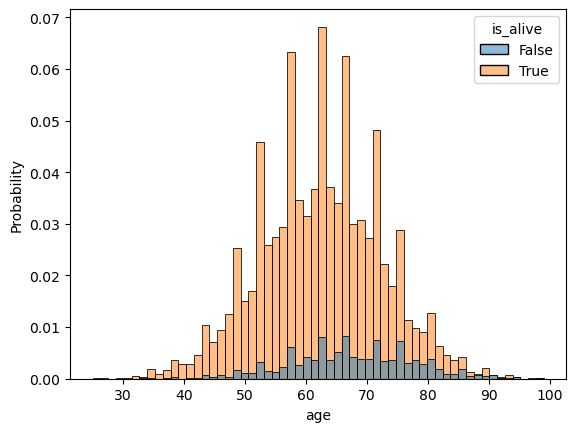

In [82]:
sns.histplot(data = dpat, x = 'age', hue = 'is_alive', stat = 'probability')
plt.show()


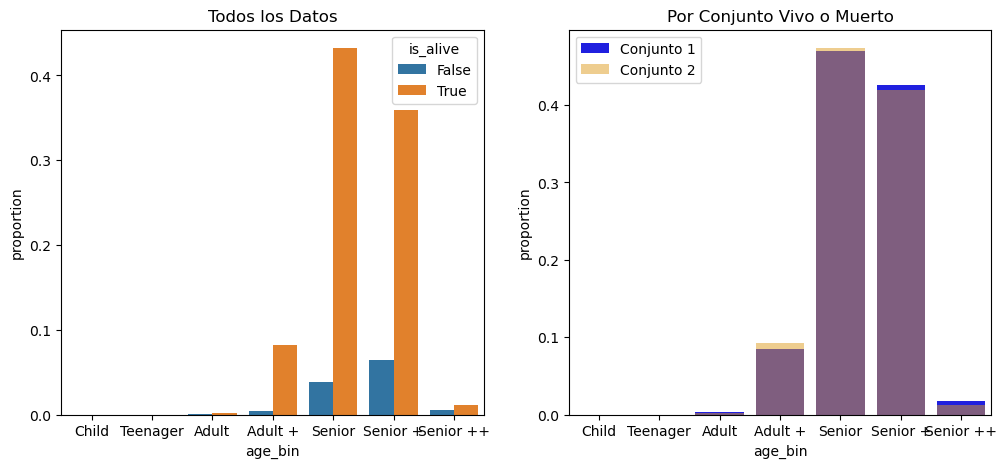

In [83]:
_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title("Todos los Datos")
sns.countplot(data = dpat,  x = 'age_bin', hue = 'is_alive', stat = 'proportion', ax = ax[0])
sns.countplot(data = dpat1, x = 'age_bin', stat = 'proportion', ax = ax[1], color = "blue"  , label = "Conjunto 1")
sns.countplot(data = dpat2, x = 'age_bin', stat = 'proportion', ax = ax[1], color = "orange", alpha = 0.5, label = "Conjunto 2")
ax[1].legend()
ax[1].set_title("Por Conjunto Vivo o Muerto")
plt.show()

In [84]:
ct = pd.crosstab(dpat['is_alive'], dpat['age_bin'])
t, pvalue, freedom, expected = st.chi2_contingency(ct, correction = False)

print(f"T: {t: 7.4f}\t P-Value: {pvalue: .3g}")
print("H0: P(T| Alive) y P(T| Dead) son independientes.")
print(f"Expected Observations")
pd.DataFrame(expected, index = ct.index, columns = ct.columns).round(1)

T:  220.2009	 P-Value:  1.7e-46
H0: P(T| Alive) y P(T| Dead) son independientes.
Expected Observations


age_bin,Adult,Adult +,Senior,Senior +,Senior ++
is_alive,,,,,
False,3.0,102.7,557.5,501.7,19.1
True,24.0,808.3,4386.5,3947.3,149.9


500


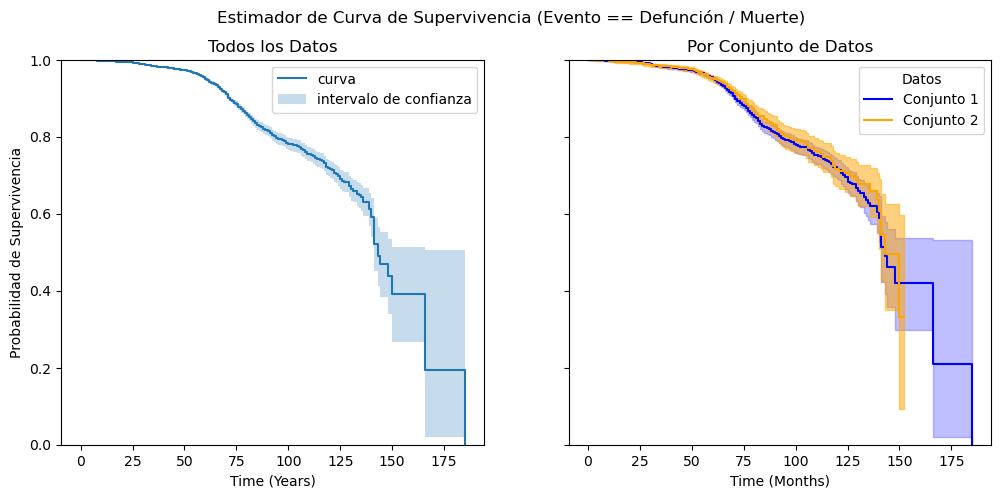

In [86]:
_, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True)
print(dpat['ehr'].duplicated().sum())

time_var = 'diag_dur'
masked_dpat = dpat.loc[dpat[['is_alive', time_var]].notna().all(axis = 1)].copy()

x, y, conf = kaplan_meier_estimator(np.logical_not(masked_dpat['is_alive'].values), time_exit = masked_dpat[time_var], conf_type = 'log-log')
ax[0].step(x, y, where = "post", label = "curva")
ax[0].fill_between(x, conf[0], conf[1], alpha = 0.25, step = "post", label = "intervalo de confianza")
ax[0].set_ylim(0, 1)
ax[0].set_xlabel("Time (Years)")
ax[0].set_ylabel("Probabilidad de Supervivencia")
ax[0].set_title("Todos los Datos")
ax[0].legend()

masked_dpat = dpat1.loc[dpat1[['is_alive', time_var]].notna().all(axis = 1)].copy()
x, y, conf = kaplan_meier_estimator(np.logical_not(masked_dpat['is_alive'].values), time_exit = masked_dpat[time_var], conf_type = 'log-log')
ax[1].step(x, y, where = "post", label = "Conjunto 1", color = 'blue')
ax[1].fill_between(x, conf[0], conf[1], alpha = 0.25, step = "post", color = "blue")

masked_dpat = dpat2.loc[dpat2[['is_alive', time_var]].notna().all(axis = 1)].copy()
x, y, conf = kaplan_meier_estimator(np.logical_not(masked_dpat['is_alive'].values), time_exit = masked_dpat[time_var], conf_type = 'log-log')
ax[1].step(x, y, where = "post", label = "Conjunto 2", color = "orange")
ax[1].fill_between(x, conf[0], conf[1], alpha = 0.5, step = "post" ,color = 'orange')

ax[1].set_ylim(0, 1)
ax[1].set_xlabel("Time (Months)")

ax[1].set_title("Por Conjunto de Datos")
ax[1].legend(title = "Datos")

plt.suptitle("Estimador de Curva de Supervivencia (Evento == Defunción / Muerte)")
plt.show()

# Datos Ginecológicos

In [87]:
gino = pd.read_excel('../data/raw/gynecological.xlsx', index_col = 0)
print("Dimensión Datos Ginecológicos:", gino.shape[0])
display(gino.head(n = 10))

Dimensión Datos Ginecológicos: 7686


,ehr,pregnancy,birth,caesarean,abort,menarche_age,menopause_age
0,10011773,-8.0,0.0,NaN,0.0,NaN,71.0
1,10030299,3.0,NaN,0.0,0.0,NaN,NaN
2,10030824,0.0,0.0,0.0,NaN,NaN,44.0
3,10053435,2.0,NaN,0.0,1.0,21.0,74.0
4,10111454,0.0,-6.0,NaN,0.0,16.0,55.0
5,10115313,2.0,0.0,0.0,2.0,18.0,44.0
6,10119160,1.0,1.0,0.0,0.0,15.0,48.0
7,10128601,3.0,NaN,0.0,0.0,14.0,53.0
8,10131227,7.0,7.0,NaN,NaN,12.0,NaN
9,10136878,NaN,5.0,10.0,0.0,10.0,NaN


In [88]:
def impute_births(row):

    row_data = row.values.tolist()
    nulls = row.isna().tolist()
    nnull = sum(nulls)

    if row[0] == 0:
        row[1:] = [0, 0, 0] # No hay embarazos, por tanto no nada en el resto
        return row

    # inconsistencia
    if row[0] < np.nansum(row[1:]): # Embarazos < Cesareas + Nacimientos + Aborto
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index = row.index)

    if nnull == 1:
        if nulls[0]: # Falta solamente el número de embarazos
            row[0] = sum(row_data[1:3])
        else: # Falta imputar el número de un tipo de resultado de un embarazo
            missing = np.where(nulls)[0][0]
            row[missing] = row_data[0] - np.nansum(row.values[1:])

    elif nnull == 2 and not nulls[0]:
        not_missing = np.where(np.logical_not(nulls[1:]))[0][0] + 1
        if row[not_missing] == row[0]: 
            row[1:] = [0, 0, 0]
            row[not_missing] = row[0]


    return row

for col in ['pregnancy', 'birth', 'caesarean', 'abort']: gino.loc[gino[col] < 0, col] = np.nan
gino[['pregnancy', 'birth', 'caesarean', 'abort']] = gino[['pregnancy', 'birth', 'caesarean', 'abort']].apply(impute_births, axis = 1)
#gino.loc[gino['menarche_age'].values < 17, 'menarche_age'] = np.nan # la media de edad de la primera menstruación dhttps://pubmed.ncbi.nlm.nih.gov/12319855/

display(gino.head(n = 10))

,ehr,pregnancy,birth,caesarean,abort,menarche_age,menopause_age
0,10011773,NaN,0.0,NaN,0.0,NaN,71.0
1,10030299,3.0,3.0,0.0,0.0,NaN,NaN
2,10030824,0.0,0.0,0.0,0.0,NaN,44.0
3,10053435,2.0,1.0,0.0,1.0,21.0,74.0
4,10111454,0.0,0.0,0.0,0.0,16.0,55.0
5,10115313,2.0,0.0,0.0,2.0,18.0,44.0
6,10119160,1.0,1.0,0.0,0.0,15.0,48.0
7,10128601,3.0,3.0,0.0,0.0,14.0,53.0
8,10131227,7.0,7.0,0.0,0.0,12.0,NaN
9,10136878,15.0,5.0,10.0,0.0,10.0,NaN


<AxesSubplot:xlabel='menopause_age', ylabel='Count'>

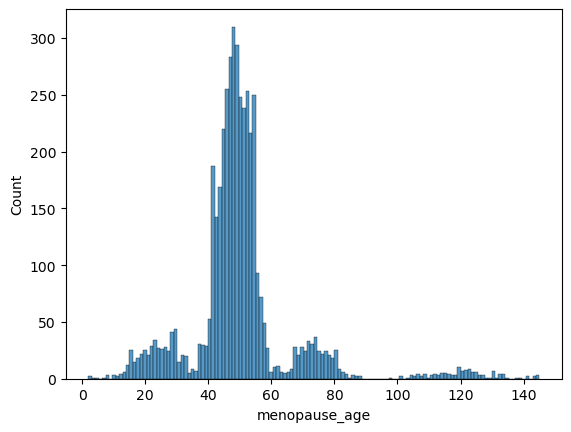

In [89]:
sns.histplot(data = gino, x = 'menopause_age')

In [100]:
gpat1 = pd.merge(dpat1, gino, on = 'ehr')
gpat2 = pd.merge(dpat2, gino, on = 'ehr')
print("gino + patients 1: ", gpat1.shape[0])
print("gino + patients 2: ", gpat2.shape[0])
gpat1.head(n = 10)

gino + patients 1:  5735
gino + patients 2:  2339


,ehr,is_alive,age,diag_dur,age_bin,pregnancy,birth,caesarean,abort,menarche_age,menopause_age
0,10011773,True,64.0,105.0,Senior,NaN,0.0,NaN,0.0,NaN,71.0
1,10030299,True,57.0,54.0,Senior,3.0,3.0,0.0,0.0,NaN,NaN
2,10030824,True,70.0,64.0,Senior +,0.0,0.0,0.0,0.0,NaN,44.0
3,10053435,True,66.0,73.0,Senior +,2.0,1.0,0.0,1.0,21.0,74.0
4,10111454,True,62.0,79.0,Senior,0.0,0.0,0.0,0.0,16.0,55.0
5,10115313,True,66.0,55.0,Senior +,2.0,0.0,0.0,2.0,18.0,44.0
6,10119160,True,61.0,73.0,Senior,1.0,1.0,0.0,0.0,15.0,48.0
7,10128601,False,67.0,72.0,Senior +,3.0,3.0,0.0,0.0,14.0,53.0
8,10131227,True,72.0,84.0,Senior +,7.0,7.0,0.0,0.0,12.0,NaN
9,10136878,True,64.0,73.0,Senior,15.0,5.0,10.0,0.0,10.0,NaN


In [101]:
def clean_repro_dates(pat, menarche_max: int = None, menopause_age: int = None, check_filter: bool = False):
    assert 'age' in pat.columns, "El conjunto de datos debe contener un campo con la edad del paciente"

    # -------------------------------------------------------------------------------------------
    # Filtro Menstruación
    # -------------------------------------------------------------------------------------------

    if check_filter: assert np.all((pat['menarche_age'].isna() | (pat['menarche_age'] > 0)).values), "Hay personas con la edad de la primera menstruación con valor negativo o nula"
    else:
        mask1 = ~(pat['menarche_age'].isna() | (pat['menarche_age'] > 0)).values
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} con la edad de la primera menstruación con valor negativo. Se han eliminado. ")
        pat.loc[mask1, 'menarche_age'] = np.nan


    if menarche_max is not None:
        if check_filter: assert np.all((pat['menarche_age'].isna() | (pat['menarche_age'] <= menarche_max)).values), f"Hay personas con la edad de la primera menstruación con valor superior al umbral de {menarche_max:3.1f}"
        else:
            mask1 = ~(pat['menarche_age'].isna() | (pat['menarche_age'] <= menarche_max)).values
            if any(mask1): 
                n_dates = sum(mask1)
                warn(f"Hay {n_dates: 5d} con la edad de la primera menstruación con valor superior al umbral de {menarche_max:3.1f}. Se han eliminado. ")
            pat.loc[mask1, 'menarche_age'] = np.nan
  

    if check_filter: assert np.all((pat['menarche_age'].isna() | (pat['menarche_age'] <= pat['age'])).values), "Hay personas con la edad de la primera menstruación mayor a su propia edad"
    else:
        mask1 = ~(pat['menopause_age'].isna() | (pat['menopause_age'] <= pat['age'])).values
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} con con la edad de la primera menstruación mayor a su propia edad. Se han eliminado")
        pat.loc[mask1, 'menarche_age'] = np.nan

    # -------------------------------------------------------------------------------------------
    # Filtro Menopausía
    # -------------------------------------------------------------------------------------------

    if check_filter: assert np.all((pat['menarche_age'].isna() | (pat['menarche_age'] > 0)).values), "Hay personas con la edad de la menopausía con valor negativo o nula"
    else:
        mask1 = ~(pat['menopause_age'].isna() | (pat['menopause_age'] > 0)).values
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} con la edad de la menopausía con valor negativo. Se han eliminado. ")
        
        pat.loc[mask1, 'menopause_age'] = np.nan

    if menopause_age is not None:
        if check_filter: assert np.all((pat['menarche_age'].isna() | (pat['menarche_age'] <= menopause_age)).values), "Hay personas con la edad de la menopausía con valor superior al umbral de {menopause_age:3.1f}"
        else:
            mask1 = ~(pat['menopause_age'].isna() | (pat['menopause_age'] <= menopause_age)).values
            if any(mask1): 
                n_dates = sum(mask1)
                warn(f"Hay {n_dates: 5d} con la edad de la menopausía con valor superior al umbral de {menopause_age:3.1f}. Se han eliminado. ")
            pat.loc[mask1, 'menopause_age'] = np.nan

    if check_filter: assert np.all((pat['menopause_age'].isna() | (pat['menopause_age'] <= pat['age'])).values), "Hay personas con la edad de la menopausía mayor a su propia edad"
    else:
        mask1 = ~(pat['menopause_age'].isna() | (pat['menopause_age'] <= pat['age'])).values
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} con con la edad de la menopausía mayor a su propia edad. Se han eliminado")
        pat.loc[mask1, 'menopause_age'] = np.nan

    return pat

gpat1 = clean_repro_dates(gpat1, 16.5, check_filter=False)    
gpat2 = clean_repro_dates(gpat2, 16.5, check_filter=False)    
display(gpat1.head(n = 10))

,ehr,is_alive,age,diag_dur,age_bin,pregnancy,birth,caesarean,abort,menarche_age,menopause_age
0,10011773,True,64.0,105.0,Senior,NaN,0.0,NaN,0.0,NaN,NaN
1,10030299,True,57.0,54.0,Senior,3.0,3.0,0.0,0.0,NaN,NaN
2,10030824,True,70.0,64.0,Senior +,0.0,0.0,0.0,0.0,NaN,44.0
3,10053435,True,66.0,73.0,Senior +,2.0,1.0,0.0,1.0,NaN,NaN
4,10111454,True,62.0,79.0,Senior,0.0,0.0,0.0,0.0,16.0,55.0
5,10115313,True,66.0,55.0,Senior +,2.0,0.0,0.0,2.0,NaN,44.0
6,10119160,True,61.0,73.0,Senior,1.0,1.0,0.0,0.0,15.0,48.0
7,10128601,False,67.0,72.0,Senior +,3.0,3.0,0.0,0.0,14.0,53.0
8,10131227,True,72.0,84.0,Senior +,7.0,7.0,0.0,0.0,12.0,NaN
9,10136878,True,64.0,73.0,Senior,15.0,5.0,10.0,0.0,10.0,NaN


In [102]:
print(gpat1.shape[0])
gpat1.isna().sum(axis = 0) / gpat1.shape[0] * 100

5735


ehr               0.000000
is_alive          0.000000
age               0.000000
diag_dur          0.697472
age_bin           0.000000
pregnancy        25.579773
birth            23.173496
caesarean        25.353095
abort            23.801221
menarche_age     45.492589
menopause_age    47.096774
dtype: float64

chemis = pd.read_json('../data/raw/histochemistry.json')
print("Tamaño: ", chemis.shape)

display(chemis.head())

chemis.info()


# Datos Tumores

In [93]:
def read_tumor_data():
    conn = connect(user = os.environ.get('PCD_DB_USR'), 
                   password = os.environ.get('PCD_DB_PWD'), 
                   host = '127.0.0.1', port = 3306, 
                   database = 'tumordb'
                    )
    data = pd.read_sql("SELECT * FROM tumor;", conn)
    conn.close()

    return data

tumor = read_tumor_data()
print("Tamaño: ", tumor.shape)
tumor.head()


DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1:3306' (10061)

Tamaño:  (10000, 5)


,ehr,er,her2,ki67,pr
0,10011773,0.0,0.0,19.0,NaN
1,10020495,1.0,0.0,9.0,0.0
2,10030299,1.0,NaN,18.0,1.0
3,10030824,1.0,0.0,NaN,1.0
4,10041592,0.0,0.0,65.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ehr     10000 non-null  int64  
 1   er      9042 non-null   float64
 2   her2    9006 non-null   float64
 3   ki67    9032 non-null   float64
 4   pr      9018 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB
